<a href="https://colab.research.google.com/github/ThiagoMSLK/files/blob/main/Profissao_Analista_de_dados_M16_2_Exercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

# Contexto

Neste projeto estudantil, em parceria com a Loggi, vamos analisar as entregas realizadas pela Loggi no Distrito Federal.

## 1\. Organização

Dados Base: Este arquivo que vamos fazer o download será a base de dados que utilizaremos.

In [1]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

O download acima contém dados de 3 geolocalizações de hubs distintos, o que é viável para trabalharmos em cima. No entanto, as entregas somam um total de 636.149 registros. Com a restrição de uma consulta por segundo no servidor do Nominatim, levaria aproximadamente 7 dias para consultar todos os registros.

Para facilitar o desenvolvimento do projeto, vamos baixar um arquivo com os dados das entregas já geolocalizados.

In [2]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

Vamos fazer o download do shapefile do Distrito Federal a partir do site oficial do IBGE e extrair os arquivos necessários para uso.

In [3]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

A única biblioteca que não vem pré-instalada no notebook e que precisaremos para este projeto, então vamos fazer o download dela.

In [4]:
!pip3 install geopandas

## 2\. Pacotes e bibliotecas

In [5]:
# - 1º pacotes nativos do python:
import json

# - 2º pacotes de terceiros:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter



## 3\. Exploração de dados

Coleta de dados

In [6]:
# Dado bruto em um dict
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

# Dado bruto no pandas
deliveries_df = pd.DataFrame(data)

# Para prosseguirmos, precisamos normalizar as colunas "origin" e "deliveries".
deliveries_df[["origin","deliveries"]].head()

,origin,deliveries
0,"{'lng': -48.05498915846707, 'lat': -15.8381445...","[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,"{'lng': -48.05498915846707, 'lat': -15.8381445...","[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,"{'lng': -48.05498915846707, 'lat': -15.8381445...","[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,"{'lng': -47.89366206897872, 'lat': -15.8051175...","[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,"{'lng': -48.05498915846707, 'lat': -15.8381445...","[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


### Wrangling da estrutura

Normalizando a coluna "origin" e salvando no hub_origin_df

In [7]:
# Normalizado
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


In [8]:
# Vamos mesclar o deliveries_df com hub_origin_df e remover a coluna "origin"
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)

# Organizando o DataFrame deliveries_df e renomeando as colunas "lng" e "lat"
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Explodindo a coluna "deliveries" e salvando no deliveries_exploded_df

In [9]:
# Explodindo
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [10]:
# Criando um DataFrame deliveries_normalized_df com as colunas delivery_size, delivery_lng e delivery_lat extraídas e normalizadas da coluna "deliveries" de deliveries_exploded_df.
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


In [11]:
# Vamos mesclar o deliveries_df com deliveries_normalized_df e remover a coluna "deliveries"
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

### Exploração do schema

In [29]:
deliveries_df.head(n=10)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055
5,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,10,-48.120448,-15.847780
6,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.121802,-15.852089
7,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,10,-48.116300,-15.851215
8,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116317,-15.849660
9,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,8,-48.123115,-15.849925


In [13]:
deliveries_df.dtypes

,0
name,object
region,object
hub_lng,float64
hub_lat,float64
vehicle_capacity,int64
delivery_size,int64
delivery_lng,float64
delivery_lat,float64


In [14]:
deliveries_df.shape

(636149, 8)

In [15]:
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [16]:
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [17]:
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [18]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


In [19]:
deliveries_df.isna().any()

,0
name,False
region,False
hub_lng,False
hub_lat,False
vehicle_capacity,False
delivery_size,False
delivery_lng,False
delivery_lat,False


## 4\. Manipulação

Enriquecimento

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

In [ ]:
# Criação do identificador do Nominatim
geolocator = Nominatim(user_agent="ebac_geocoder")

# Teste usando o HUB df-0
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

In [ ]:
# Definindo delay de consulta no server do Nominatim para 1 segundo
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
# Criando a coluna 'coordinates' juntando as informações das colunas hub_lat e hub_lng em uma sring unica
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)

# Aplicando o 'geolocator'/'geocoder' para criar a coluna 'geodata'(em JSON) usando as coordenadas da coluna
# 'coordinates' para encontrar o endereço de cada hub da Loggi no Destrito Federal
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)

hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [ ]:
# Normalizando a coluna 'geodata' e adiocionando na varivale hub_geodata_df
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))

hub_geodata_df.head()

In [ ]:
# Filtrando as colunas de interesse
hub_geodata_df = hub_geodata_df[['address.town', 'address.suburb', 'address.city']]

In [ ]:
# Alterando os nomes das colunas filtrada
# OBS: inplace=True aplica as alterações no proprio DataFrame sem precisar criar outro ou atribuir ao proprio
hub_geodata_df.rename(columns={'address.town': 'hub_town', 'address.suburb':'hub_suburb', 'address.city':'hub_city'}, inplace=True)

In [ ]:
# Se a alguma linha da coluna 'hub_city' estiver nula(vazia)
# ela vai receber a informação da mesma linha da coluna 'hub_town'
hub_geodata_df['hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town'])

# Se a alguma linha da coluna 'hub_suburb' estiver nula(vazia)
# ela vai receber a informação da mesma linha da coluna 'hub_city'
hub_geodata_df['hub_suburb'] = np.where(hub_geodata_df['hub_suburb'].notna(), hub_geodata_df['hub_suburb'], hub_geodata_df['hub_city'])

# Dropando a coluna 'hub_town'
# Não esquecer usar axis=1 para remover a coluna se não o Pandas vai tentar remover uma linha
hub_geodata_df = hub_geodata_df.drop('hub_town', axis=1)

hub_geodata_df.head()

In [ ]:
# Mesclando o hub_df com o hub_geodata_df
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)

# Filtrando as colunas de interesse
hub_df = hub_df[['region', 'hub_suburb', 'hub_city']]

In [ ]:
# Mesclando deliveries_df com hub_df usando a coluna em comum 'region' como base
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how='inner', on='region')

# Organizando a ordem das colunas o DataFrame deliveries_df
deliveries_df = deliveries_df[['name','region','hub_lng', 'hub_lat', 'hub_city', 'hub_suburb', 'vehicle_capacity', 'delivery_lng', 'delivery_lat']]

Como mencionado no início do notebook, fizemos o download do arquivo com as entregas já geolocalizadas. Vamos começar a utilizá-lo agora.

In [ ]:
# Criando um DataFrame com o arquivo
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

In [ ]:
# Mesclando o deliveries_df com deliveries_geodata_df em especifico as colunas "'delivery_city', 'delivery_suburb'"
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

Controle de qualidade

In [ ]:
deliveries_df.head(n=10)

In [ ]:
deliveries_df.dtypes

In [ ]:
deliveries_df.shape

In [ ]:
deliveries_df.columns

In [ ]:
deliveries_df.index

In [ ]:
deliveries_df.select_dtypes("object").describe().transpose()

In [ ]:
deliveries_df.info()

In [ ]:
100 * (deliveries_df['delivery_city'].isna().sum() / len(deliveries_df))

In [ ]:
100 * (deliveries_df['delivery_suburb'].isna().sum() / len(deliveries_df))

In [ ]:
prop_df = deliveries_df[['delivery_city']].value_counts() / len(deliveries_df)
prop_df.head(n=10)

In [ ]:
prop_df = deliveries_df[['delivery_suburb']].value_counts() / len(deliveries_df)
prop_df.head(n=10)

In [ ]:
deliveries_df.isna().any()

## 5\. Visualização

Shapefile

In [ ]:
# Lendo o Shapefile e escolhendo o mapa do Destrito Federal
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

In [ ]:
# Criando um novo DataFrame com apenas a geolocalização dos HUBs
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

In [ ]:
# Criando um novo DataFrame com apenas a geolocalização das entregas
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

Graficos

Mapa com as entregas e os HUBs

<ipython-input-61-9f30c304fe89>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


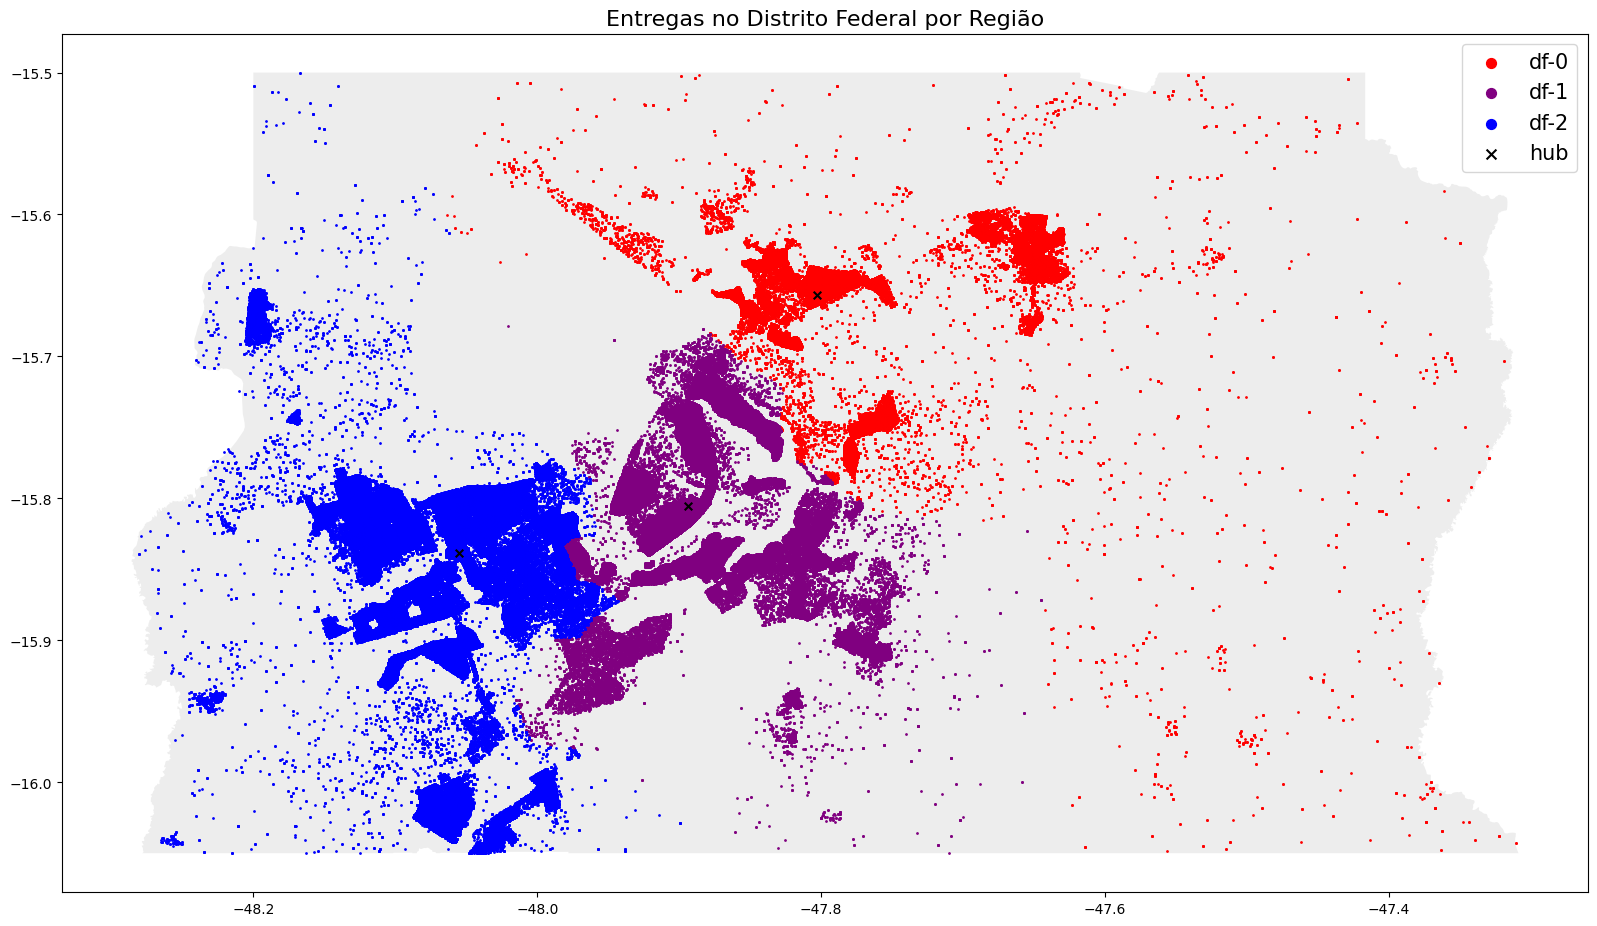

In [ ]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="purple", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="blue", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

Grafico de Barras

In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,proportion
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


<ipython-input-60-4e5092e1fa1e>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="proportion", ci=None, palette="pastel")
<ipython-input-60-4e5092e1fa1e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="proportion", ci=None, palette="pastel")


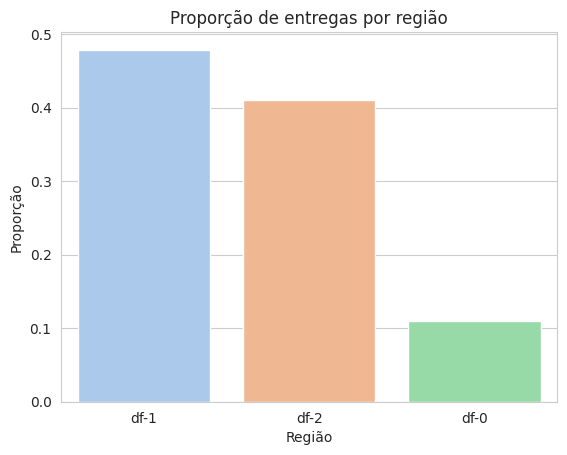

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="proportion", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

## 6\. Análises


### Entregas

In [20]:
deliveries_df.groupby(["region"]).count()

,name,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
region,,,,,,,
df-0,70122,70122,70122,70122,70122,70122,70122
df-1,304708,304708,304708,304708,304708,304708,304708
df-2,261319,261319,261319,261319,261319,261319,261319


,region,deliveries
0,df-0,70122
1,df-1,304708
2,df-2,261319


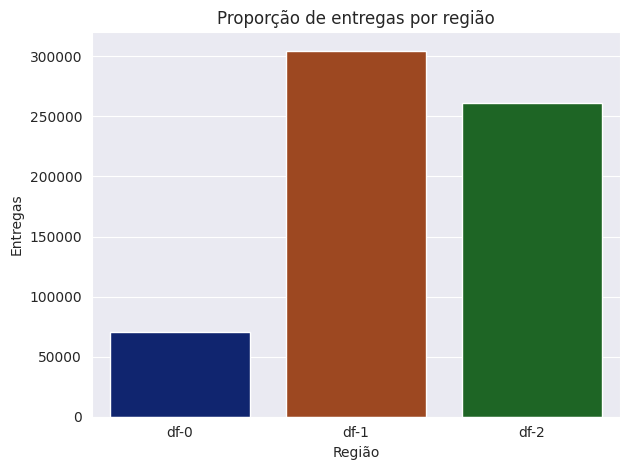

In [101]:
region = pd.DataFrame(deliveries_df.groupby(["region"]).count().reset_index())
region = region[["region","name"]].rename(columns={"name":"deliveries"})
region.head()
with sns.axes_style('darkgrid'):
  grafico = sns.barplot(data=region, x="region", y="deliveries", hue="region", legend=False, palette="dark")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Entregas')
  plt.tight_layout()
region

**Insights**: Podemos observar que o HUB-0 (df-0) possui uma demanda significativamente inferior em comparação com os outros dois hubs. Em contrapartida, o HUB-1 (df-1) apresenta uma demanda muito superior, com uma diferença de mais de 40 mil em relação ao HUB-2 (df-2), que é o segundo maior em demanda.

### Capacidade

In [22]:
# Capacidade média dos veículos
deliveries_df.groupby("name")["vehicle_capacity"].agg("mean")

,vehicle_capacity
name,
cvrp-0-df-1,180.0
cvrp-0-df-10,180.0
cvrp-0-df-11,180.0
cvrp-0-df-12,180.0
cvrp-0-df-13,180.0
...,...
cvrp-2-df-81,180.0
cvrp-2-df-82,180.0
cvrp-2-df-84,180.0


Podemos observar que a capacidade padrão de cada veículo é de 180 unidades, seja em metros cúbicos ou quilogramas (não está especificado qual).

In [30]:
# Capacidade necessária para cada entrega
deliveries_df[["name","vehicle_capacity","delivery_size"]].groupby("name")["delivery_size"].agg("sum")

,delivery_size
name,
cvrp-0-df-1,5680
cvrp-0-df-10,5533
cvrp-0-df-11,4993
cvrp-0-df-12,4440
cvrp-0-df-13,5612
...,...
cvrp-2-df-81,24288
cvrp-2-df-82,26604
cvrp-2-df-84,20225


In [95]:
# Viagens necessárias para fazer todas as entregar
deliveries_df[["name","vehicle_capacity","delivery_size"]].groupby("name")["delivery_size"].agg("sum") / 180

,delivery_size
name,
cvrp-0-df-1,31.555556
cvrp-0-df-10,30.738889
cvrp-0-df-11,27.738889
cvrp-0-df-12,24.666667
cvrp-0-df-13,31.177778
...,...
cvrp-2-df-81,134.933333
cvrp-2-df-82,147.800000
cvrp-2-df-84,112.361111


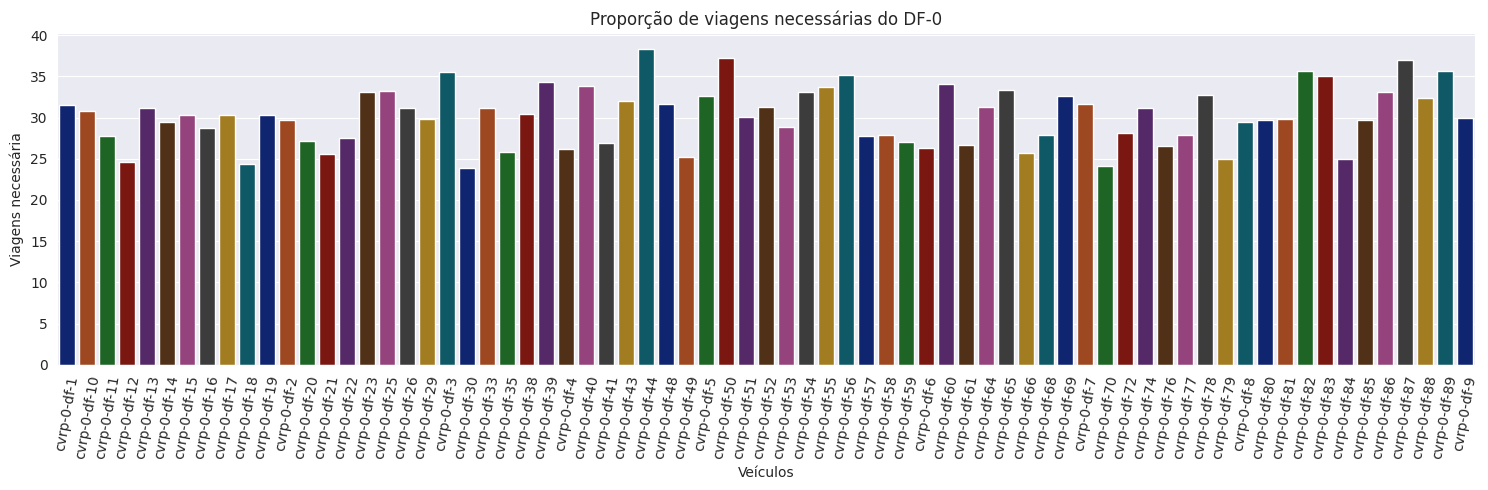

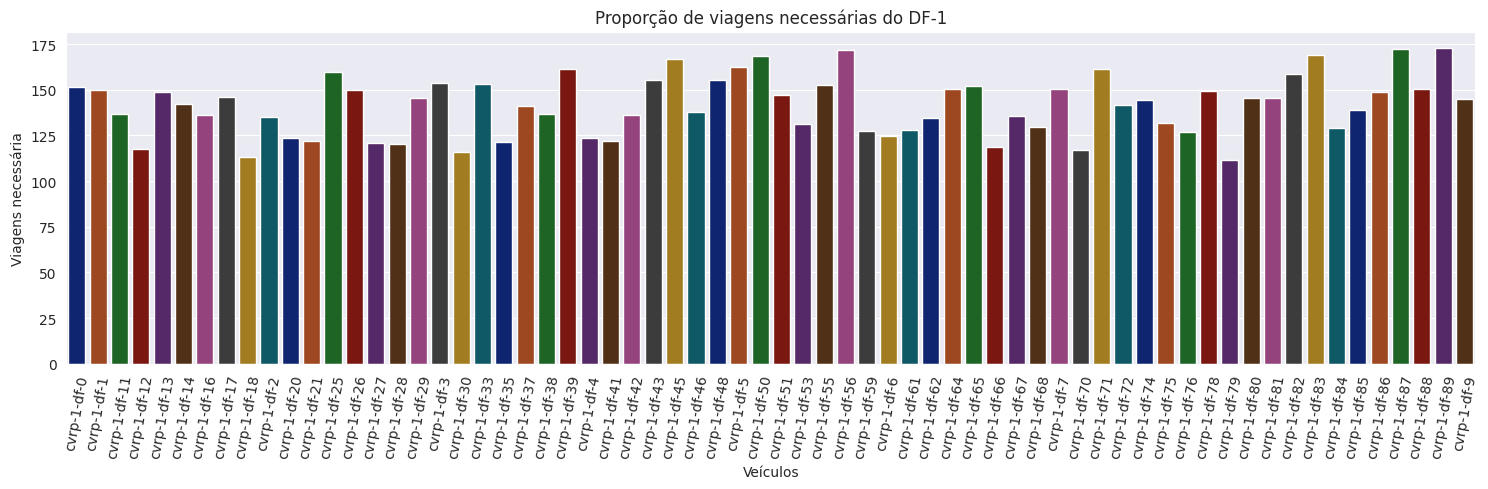

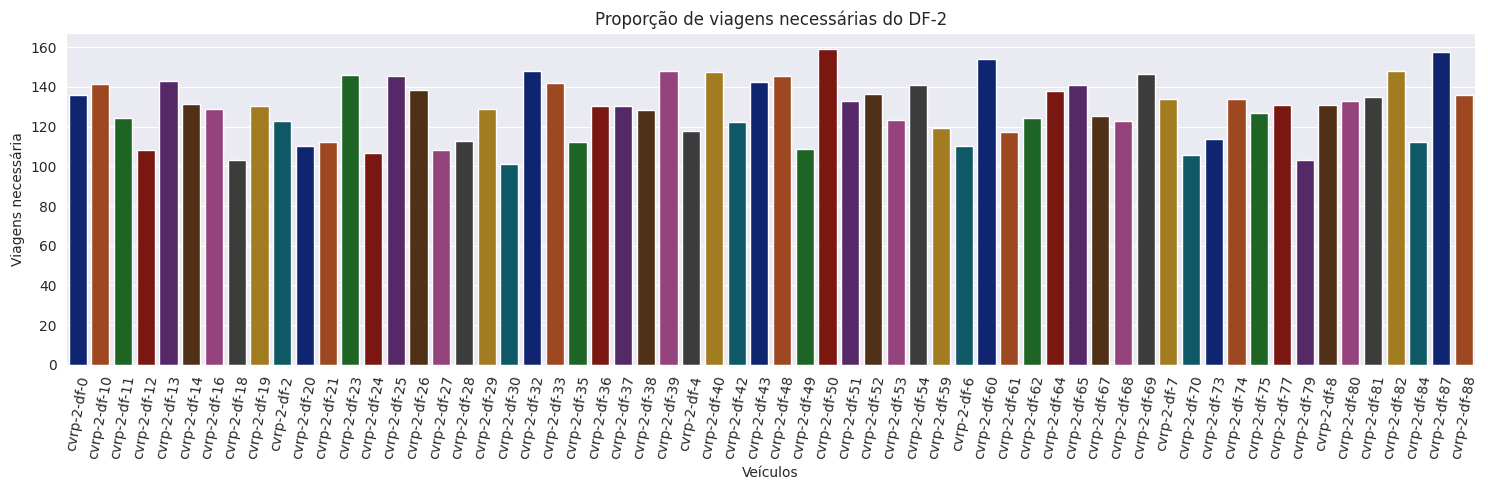

In [80]:
travel = pd.DataFrame(deliveries_df[["name","region","delivery_size"]].groupby(["name","region"])["delivery_size"].agg("sum") / 180).reset_index()
for df in travel["region"].unique():
  hub = travel.query(f"region == '{df}'")
  with sns.axes_style('darkgrid'):
    plt.figure(figsize=(15, 5))
    grafico = sns.barplot(data=hub, x="name", y="delivery_size", hue="name", legend=False, palette="dark")
    grafico.set(title=f'Proporção de viagens necessárias do {df.upper()}', xlabel='Veículos', ylabel='Viagens necessária')
    plt.xticks(rotation=80)
    plt.tight_layout()


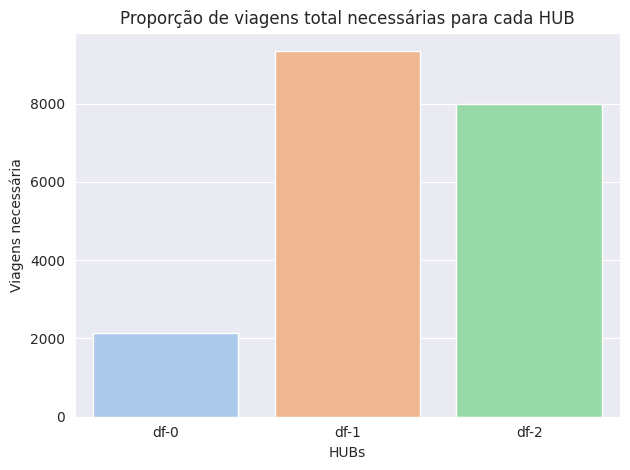

In [98]:
travel_hub = pd.DataFrame(deliveries_df[["name","region","delivery_size"]].groupby(["region"])["delivery_size"].agg("sum") / 180).reset_index()
with sns.axes_style('darkgrid'):
  grafico = sns.barplot(data=travel_hub, x="region", y="delivery_size", hue="region", legend=False, palette="pastel")
  grafico.set(title='Proporção de viagens total necessárias para cada HUB', xlabel='HUBs', ylabel='Viagens necessária')

  plt.tight_layout()

In [103]:
comparison = pd.merge(left=travel_hub, right=region, how='inner', on='region')
comparison.head()

,region,delivery_size,deliveries
0,df-0,2144.066667,70122
1,df-1,9342.122222,304708
2,df-2,7994.500000,261319


**Insights**: Confirmando o insight anterior da seção de Entregas, podemos concluir que a logística da Loggi no Distrito Federal é excelente. A análise dos dados mostra uma gestão eficaz das entregas, otimização das rotas e uma distribuição eficiente dos recursos, resultando em um sistema logístico bem estruturado e funcional na região.